In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Started January 16th 2017


# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [62]:
from __future__ import print_function
import os
import sys
import tensorflow as tf
import idx2numpy
import numpy as np
import random
from PIL import Image, ImageDraw
from PIL import Image

import math
import h5py
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (3.0, 3.0)

#### Creating a synthetic dataset by concatenating 5 MNIST digits

This [forum discussion](https://discussions.udacity.com/t/step-1-concatenation-of-mnist/207676/5) was refered and the code was copied from there. 

1. Downloaded all idx.gz files by Chrome web browser to the current working directory. 
2. Installed idx2numpy: sudo -H pip install idx2numpy
3. Extracted all 4 gz files: for example, gunzip -k  train-labels-idx1-ubyte.gz
4. Manually added idx extension to the file name in the current working directory. 

In [6]:
# read data and convert idx file to numpy array

ndarr_train = idx2numpy.convert_from_file('train-images-idx3-ubyte.idx')
labels_raw_train = idx2numpy.convert_from_file('train-labels-idx1-ubyte.idx')
ndarr_test = idx2numpy.convert_from_file('t10k-images-idx3-ubyte.idx')
labels_raw_test = idx2numpy.convert_from_file('t10k-labels-idx1-ubyte.idx')

print('ndarr_train.shape--',ndarr_train.shape)
print('labels_raw_train.shape--',labels_raw_train.shape)
print('ndarr_test.shape--',ndarr_test.shape)
print('labels_raw_test--',labels_raw_test.shape)


ndarr_train.shape-- (60000, 28, 28)
labels_raw_train.shape-- (60000,)
ndarr_test.shape-- (10000, 28, 28)
labels_raw_test-- (10000,)


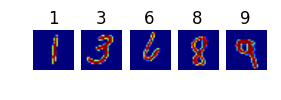

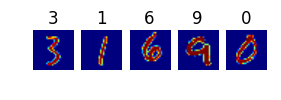

In [37]:
#Checking MNIST dataset and label

num_subplots=5
randomIndex=np.sort(np.random.randint(0, ndarr_test.shape[0], size=num_subplots))

def display_Image_Label(num_subplots, dataset, data_labels):
    f, ax = plt.subplots(nrows=1, ncols=num_subplots)
    for i,j in enumerate(randomIndex):
        img=Image.fromarray(dataset[j,:,:])
        ax[i].axis('off')
        ax[i].set_title(data_labels[j], loc='center')
        ax[i].imshow(img)
    return

display_Image_Label(num_subplots, ndarr_train, labels_raw_train)
display_Image_Label(num_subplots, ndarr_test, labels_raw_test)

In [34]:
#random shuffle MNIST data

#trainset
shuffled_train_index=[]
shuffled_train_label=[]

shuffled_train_index=np.arange(len(labels_raw_train))
np.random.shuffle(shuffled_train_index)
shuffled_train_dataset=ndarr_train[shuffled_train_index,:,:]

for ix,newidx in enumerate(shuffled_train_index):
    shuffled_train_label.append(labels_raw_train[newidx])

shuffled_train_label=np.array(shuffled_train_label)

#testset
shuffled_test_index=[]
shuffled_test_label=[]

shuffled_test_index=np.arange(len(labels_raw_test))
np.random.shuffle(shuffled_test_index)
shuffled_test_dataset=ndarr_test[shuffled_test_index,:,:]

for ix,newidx in enumerate(shuffled_test_index):
    shuffled_test_label.append(labels_raw_test[newidx])

shuffled_test_label=np.array(shuffled_test_label)


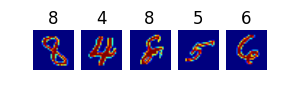

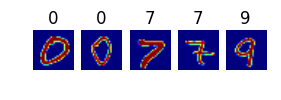

In [38]:
#Check if data is still fine after shuffle

display_Image_Label(num_subplots, shuffled_train_dataset, shuffled_train_label)
display_Image_Label(num_subplots, shuffled_test_dataset, shuffled_test_label)


In [39]:
#Concatenate 5 single digits

image_height = 28
image_width = 140 # 28*5 
num_digit=5

def createSequences(ndarr,labels_raw):
    
    dataset_size = ndarr.shape[0]/5
    dataset=[]
    data_labels = []
    
    dataset = np.ndarray(shape=(dataset_size, image_height, image_width),dtype=np.float32)
    data_labels=np.ndarray(shape=(dataset_size,num_digit+1),dtype=np.int32)

    i = 0
    w = 0
    while i < dataset_size: #dataset_size
        temp = np.hstack(
            [ndarr[w], ndarr[w + 1], ndarr[w + 2], ndarr[w + 3], ndarr[w + 4]])
        dataset[i, :, :] = temp
        temp_str = np.hstack([labels_raw[w], labels_raw[w + 1], labels_raw[w + 2], labels_raw[w + 3], labels_raw[w + 4], 
                    num_digit])
        data_labels[i,:]=temp_str #.append(temp_str)
        w += 5
        i += 1

    np.array(data_labels)

    return dataset, data_labels

concat_dataset_train, concat_data_labels_train = createSequences(shuffled_train_dataset,shuffled_train_label)
concat_dataset_test, concat_data_labels_test = createSequences(shuffled_test_dataset,shuffled_test_label)

In [40]:
#checking the concatenated data dimension

print('concat_dataset_train---',concat_dataset_train.shape)
print('concat_data_labels_train---',concat_data_labels_train.shape) 
print('concat_dataset_test---',concat_dataset_test.shape)
print('concat_data_labels_test---',concat_data_labels_test.shape)

concat_dataset_train--- (12000, 28, 140)
concat_data_labels_train--- (12000, 6)
concat_dataset_test--- (2000, 28, 140)
concat_data_labels_test--- (2000, 6)


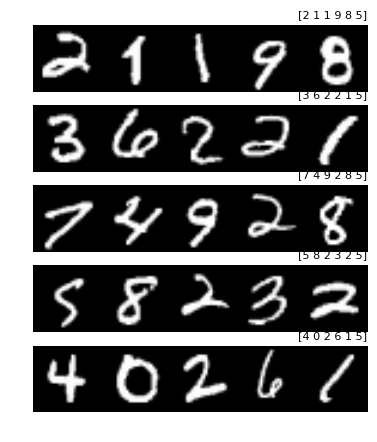

In [49]:
#display random sample to check if data is ok after creating sequences

plt.rcParams['figure.figsize'] = (5.0, 5.0)

def display_Image_Label(num_subplots, dataset, data_labels):
    f, ax = plt.subplots(nrows=num_subplots, ncols=1)
    for i,j in enumerate(randomIndex):
        img=Image.fromarray(dataset[j,:,:])
        ax[i].axis('off')
        ax[i].set_title(data_labels[j], loc='right',fontsize=8)
        ax[i].imshow(img)
    return

display_Image_Label(num_subplots, concat_dataset_train,concat_data_labels_train)


In [50]:
#padding to make image square input and resize to 28X28

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.0, 5.0)

img=Image.fromarray(concat_dataset_train[0])
img2=Image.fromarray(concat_dataset_train[1])


longer_side = max(img.size) #(252, 143)
horizontal_padding = (longer_side - img.size[0]) / 2
vertical_padding = (longer_side - img.size[1]) / 2
img2 = img.crop(
    (
        -horizontal_padding,
        -vertical_padding,
        img.size[0] + horizontal_padding,
        img.size[1] + vertical_padding
    )
)

img.size== (140, 28)
img2.size== (140, 140)
<class 'PIL.Image.Image'>
img3_resized_from_140_140.size= (50, 50)
<type 'numpy.ndarray'>


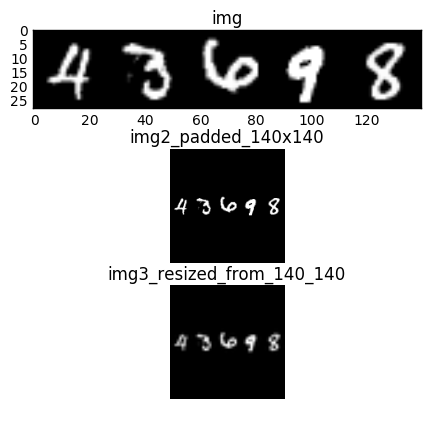

In [12]:
#checking how image quality degraded by padding and downsampling

f, ax = plt.subplots(nrows=3, ncols=1)

ax[0].set_title('img', loc='center')
print('img.size==',img.size)
ax[0].imshow(img)

ax[1].set_title('img2_padded_140x140', loc='center')
ax[1].axis('off')
print('img2.size==',img2.size)
ax[1].imshow(img2)

img3_resized_from_140_140=img2.resize((50,50),Image.ANTIALIAS)
print(type(img3_resized_from_140_140))
ax[2].set_title('img3_resized_from_140_140', loc='center')
ax[2].axis('off')
print('img3_resized_from_140_140.size=',img3_resized_from_140_140.size)
ax[2].imshow(img3_resized_from_140_140)
backtoarray=np.array(img3_resized_from_140_140)
print(type(backtoarray))

In [52]:
#pad and resize all samples:

def pad_resize_to_square(rectangular_array, finalsize): #28x140
    img=Image.fromarray(rectangular_array)
    longer_side = max(img.size) 
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    
    padded_img = img.crop(
                        (
                            -horizontal_padding,
                            -vertical_padding,
                            img.size[0] + horizontal_padding,
                            img.size[1] + vertical_padding
                        )
                    )

    img_resized=padded_img.resize((finalsize,finalsize),Image.ANTIALIAS)
    back_to_array=np.array(img_resized)
    return back_to_array

In [53]:
#convert all from 28x140 to 70x70:
finalsize=70
sqr_concat_dataset_train=[]

#trainset
for i in range(0,len(concat_dataset_train)):
    sqr_tmp=pad_resize_to_square(concat_dataset_train[i],finalsize)
    sqr_concat_dataset_train.append(sqr_tmp)
    i+=1
        
sqr_concat_dataset_train=np.array(sqr_concat_dataset_train)
print(sqr_concat_dataset_train.shape)

(12000, 70, 70)


In [54]:
#testset
sqr_concat_dataset_test=[]
for i in range(0,len(concat_dataset_test)):
    sqr_tmp=pad_resize_to_square(concat_dataset_test[i],finalsize)
    sqr_concat_dataset_test.append(sqr_tmp)
    i+=1
        
sqr_concat_dataset_test=np.array(sqr_concat_dataset_test)
print(sqr_concat_dataset_test.shape)

(2000, 70, 70)


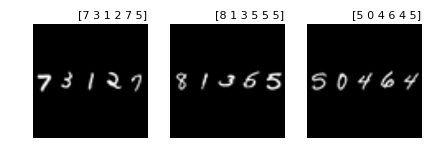

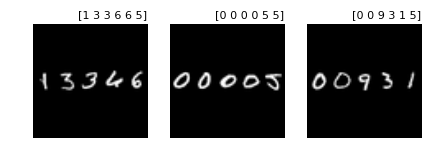

In [62]:
#check if other paded images are fine after downsizing

randomIndex=np.sort(np.random.randint(0, sqr_concat_dataset_test.shape[0], size=num_subplots))
num_subplots=3

def display_Image_Label(num_subplots, dataset, data_labels):
    f, ax = plt.subplots(nrows=1, ncols=num_subplots)
    for i,j in enumerate(randomIndex):
        img=Image.fromarray(dataset[j,:,:])
        ax[i].axis('off')
        ax[i].set_title(data_labels[j], loc='right',fontsize=8)
        ax[i].imshow(img)
    return

display_Image_Label(num_subplots, sqr_concat_dataset_train, concat_data_labels_train)
display_Image_Label(num_subplots, sqr_concat_dataset_test, concat_data_labels_test)

In [63]:
# split train data to validation set and train set 

train_dataset = sqr_concat_dataset_train[2000:,:,:] #--- original (12000, 28, 140)
train_labels = concat_data_labels_train[2000:] #--- 12000

valid_dataset = sqr_concat_dataset_train[:2000,:,:]
valid_labels = concat_data_labels_train[:2000] 

test_dataset = sqr_concat_dataset_test #--- (2000, 28, 140)
test_labels = concat_data_labels_test #--- 2000

print('train:',train_dataset.shape, train_labels.shape)
print('valid:',valid_dataset.shape, valid_labels.shape)
print('test:',test_dataset.shape, test_labels.shape)

print('test_labels[0]---',test_labels[0])

train: (10000, 70, 70) (10000, 6)
valid: (2000, 70, 70) (2000, 6)
test: (2000, 70, 70) (2000, 6)
test_labels[0]--- [1 1 3 9 2 5]


In [64]:
#reformat all data to 4d array

image_size = 70
num_channels = 1 # grayscale

def reformat(dataset): #, labels
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  #labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32) #one hot coding
  return dataset #, labels

train_dataset = reformat(train_dataset) #, train_labels   
valid_dataset = reformat(valid_dataset) #, valid_labels
test_dataset = reformat(test_dataset) #, test_labels

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (10000, 70, 70, 1) (10000, 6)
Validation set (2000, 70, 70, 1) (2000, 6)
Test set (2000, 70, 70, 1) (2000, 6)


In [65]:
#before tensorflow training, define accuracy

def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [21]:
#Final optimized net for synthetic data for digit classification: accuracy 91% after training 10000 dataset. 

image_size=70
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=1 #no pooling=0.5
W_fc_shape=int((image_size/(2*pooling))*(image_size/(2*pooling))*depth2)


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth2], stddev=0.1)) #POR 0.1
  b_conv1 = tf.Variable(tf.zeros([depth2]))
    
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  def max_pool_1x1(x):
    return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],strides=[1, 1, 1, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    #data = tf.reshape(data,(-1, image_size*image_size))
    print('data---',data.get_shape())
    
    ######Stage1########
    print("********Stage1**********")
    conv=conv2d(data, W_conv1) + b_conv1
    print('conv==',conv.get_shape())
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1)  
    print('h_pool1 ==',h_pool1.get_shape()) #h_pool1 == (64, 35, 35, 32)
    
    ######Stage2=fully connected and dropout ########
    print("********Stage2: fully connected**********")
    
    print('W_fc_shape==',W_fc_shape) #W_fc_shape== 19600

    
    #variable
    h_pool1_flat = tf.reshape(h_pool1, [-1, W_fc_shape]) 
    print('h_pool1_flat==',h_pool1_flat.get_shape())
  
    logits_0=tf.matmul(h_pool1_flat, W_fc_0) + b_fc_0 #h_pool1_flat== (-1, W_fc_shape), W_fc_0=[W_fc_shape, num_labels]
    logits_1=tf.matmul(h_pool1_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool1_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool1_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool1_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]

  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_train_dataset)
  
  print('logits_0--',logits_0.get_shape())
  print('tf_train_labels---',tf_train_labels.get_shape())
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,0], logits=logits_0))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits_1))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits_2))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits_3))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits_4))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data. 
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),
                              tf.nn.softmax(model(tf_train_dataset)[1]),
                              tf.nn.softmax(model(tf_train_dataset)[2]),
                              tf.nn.softmax(model(tf_train_dataset)[3]),
                              tf.nn.softmax(model(tf_train_dataset)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),
                              tf.nn.softmax(model(tf_valid_dataset)[1]),
                              tf.nn.softmax(model(tf_valid_dataset)[2]),
                              tf.nn.softmax(model(tf_valid_dataset)[3]),
                              tf.nn.softmax(model(tf_valid_dataset)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                             tf.nn.softmax(model(tf_test_dataset)[1]),
                             tf.nn.softmax(model(tf_test_dataset)[2]),
                             tf.nn.softmax(model(tf_test_dataset)[3]),
                             tf.nn.softmax(model(tf_test_dataset)[4])])

num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:5]))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:5]))
  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))

data--- (64, 70, 70, 1)
********Layer1**********
conv== (64, 70, 70, 32)
h_pool1 == (64, 35, 35, 32)
********Stage2: fully connected**********
W_fc_shape== 39200
h_pool1_flat== (64, 39200)
logits_0-- (64, 11)
tf_train_labels--- (64, 6)
data--- (64, 70, 70, 1)
********Layer1**********
conv== (64, 70, 70, 32)
h_pool1 == (64, 35, 35, 32)
********Stage2: fully connected**********
W_fc_shape== 39200
h_pool1_flat== (64, 39200)
data--- (64, 70, 70, 1)
********Layer1**********
conv== (64, 70, 70, 32)
h_pool1 == (64, 35, 35, 32)
********Stage2: fully connected**********
W_fc_shape== 39200
h_pool1_flat== (64, 39200)
data--- (64, 70, 70, 1)
********Layer1**********
conv== (64, 70, 70, 32)
h_pool1 == (64, 35, 35, 32)
********Stage2: fully connected**********
W_fc_shape== 39200
h_pool1_flat== (64, 39200)
data--- (64, 70, 70, 1)
********Layer1**********
conv== (64, 70, 70, 32)
h_pool1 == (64, 35, 35, 32)
********Stage2: fully connected**********
W_fc_shape== 39200
h_pool1_flat== (64, 39200)
data--- 

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

**Data pre-processing**

Based on the [forum discussion](https://discussions.udacity.com/t/step-1-concatenation-of-mnist/207676), MNIST data was randomly shuffled, concatenated to 28x140 images. Then, images were padded along the short dimension to make a square input of 140x140 and resized to 70x70. 

**Convnet architecture**

**Experiment (1)**   
Only fully connected layer was inserted in a net, and 83% accuracy was achieved in testset.   
**Experiment (2)**   
then, conv2d 1x1-maxpool 1x1 were added and 87.8% was achieved.   
**Experiment (3)**   
When initializer was set with std=0, accuracy dropped down to 46.7%. Learned that giving small but non-zero std variation during initialization is important.   
**Experiment (4)**   
Made maxpool as 2x2 and varied the number of output channel(4th dimension) for conv2d layer. depth0(1 pixel) dropped down the accuracy to 68.6%. When changed to depth1(16), it went back upto 91.7%, however, further change to depth2(32) doesn't improve accuracy any further(91.5%). This means, depth of convolusion is critical hyperparameter to optimize. 
Depth that were varied:  
        - depth1 = 16  
        - depth2 = 32  
        - depth3 = 64  
        - depth4 = 128  
        - depth5 = 1024  

**Experiment (5)**   
Another conv2d 1x1, and maxpool 2x2 were added additionally and the depth(number of output channel) parameter was varied for conv2d, but accuracy didn't further improve, therefore, one conv2d-maxpool 2x2 stage architecture was settled. 

**Experiment (6)**   
Increasing learning rate from 1e-8 to 1e-2 improved accuracy.
Changing optimizer from GradientDescentOptimizer to AdagradOptimizer improved accuracy. 


### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

A very simple, 1 convolution->relu->2x2 maxpool->fully connected layer to the final classifier was used.
Then, 5 classifiers were implemented to classify each digit based the codes in ipynb that [Hang_Yao](https://github.com/hangyao/street_view_house_numbers/blob/master/4_CNN_multi.ipynb) shared in [Udacity forum](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897/9).


Total 2 stages,   
    
    Stage1: one convolution layer(conv) with 5x5 patch with stride 1x1->relu->2x2 maxpool(h_pool1)  
    Stage2: fully connected layer(h_pool1_flat) -> 5 logits/classifiers   

were used. Each layer changes sizes as following:

    input data : (batch size, 70, 70, 1)
    input data labels : (batch size, 6)
    
    ********Stage1: conv and maxpool**********
    conv== (batch size, 70, 70, 32)
    h_pool1 == (batch size, 35, 35, 32)

    ********Stage2: fully connected***********
    h_pool1_flat== (batch size, 39200) #35x35x32
    logits_0-- (batch size, 11) #total 11 digits(0~10)
    logits_1-- (batch size, 11)
    logits_2-- (batch size, 11)
    logits_3-- (batch size, 11)
    logits_4-- (batch size, 11)
    


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

As mentioned in Question 1, MNIST data of single digit image(28x28)-label pair (total 60000 trainset, 10000 testset) was randomly shuffled, 5 digits were concatenated to create 28x140 size. Then, images were padded along the short dimension to make a square input of 140x140 and resized to 70x70. Among 12000 trainset, first 2000 trainset was saved to validation set, and the rest 10000 trainset was saved to the final trainset. Total testset is 2000 set. Training was done with the architecture mentioned above while valid dataset was being checked during training. 

One example of syntetic data is:

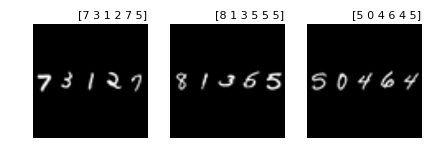

In [66]:
display_Image_Label(num_subplots, sqr_concat_dataset_train, concat_data_labels_train)

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preprocessing  

Downloaded train.tar.gz,test.tar.gz,extra.tar.gz from [the suggested website](http://ufldl.stanford.edu/housenumbers/) and extract them to each folder. The methodology of extracting bounding box/label information for each image file was from [Hang Yao's code](https://github.com/hangyao/street_view_house_numbers)

In [121]:
#bounding box extraction from mat file in hdf5 format

def extract_boundingbox(mat_file):
    '''
    ## input: hdf5 mat file
    ## output format

    [{'boxes': [{'width': 19.0, 'top': 7.0, 'height': 30.0, 'label': 5.0, 'left': 43.0}], 'filename': '1.png'}, 
     {'boxes': [{'width': 14.0, 'top': 5.0, 'height': 23.0, 'label': 2.0, 'left': 99.0}, 
                {'width': 12.0, 'top': 6.0, 'height': 23.0, 'label': 10.0, 'left': 121.0}], 'filename': '2.png'}]
    '''

    f=h5py.File(mat_file, 'r')

    digitStructName = f['digitStruct']['name']
    digitStructBbox = f['digitStruct']['bbox']
    bbox = {}
    result=[]
    item={}

    for n in np.arange(0,len(digitStructName)): ## iterate every file
        
        if (len(f[digitStructBbox[n].item()]["height"]) > 1):
            bbox['top'] = [f[f[digitStructBbox[n].item()]["top"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["top"]))]
            bbox['left'] = [f[f[digitStructBbox[n].item()]["left"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["left"]))]
            bbox['height'] = [f[f[digitStructBbox[n].item()]["height"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["height"]))]
            bbox['width'] = [f[f[digitStructBbox[n].item()]["width"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["width"]))]
            bbox['label'] = [f[f[digitStructBbox[n].item()]["label"].value[j].item()].value[0][0] 
                              for j in range(len(f[digitStructBbox[n].item()]["label"]))]   
        else:
            bbox['top'] = [f[digitStructBbox[n].item()]["top"].value[0][0]]
            bbox['left'] = [f[digitStructBbox[n].item()]["left"].value[0][0]]
            bbox['height'] = [f[digitStructBbox[n].item()]["height"].value[0][0]]
            bbox['width'] = [f[digitStructBbox[n].item()]["width"].value[0][0]]
            bbox['label'] = [f[digitStructBbox[n].item()]["label"].value[0][0]]

        item={'filename':''.join([chr(c[0]) for c in f[digitStructName[n][0]].value])}
        figures = []   
        for i in range(len(f[digitStructBbox[n].item()]["height"])):
            figure={}
            figure['top']=bbox['top'][i]
            figure['left']=bbox['left'][i]
            figure['height']=bbox['height'][i]
            figure['width']=bbox['width'][i]
            figure['label']=bbox['label'][i]
            figures.append(figure)
        item['boxes'] = figures
        result.append(item)
    
    return result

In [68]:
#Read bounding box,filename, and label information

train_folders = './train/'
test_folders = './test/'
extra_folders = './extra/'

#extract bbox and filename from all dataset "test_bboxdata"

test_bboxdata=extract_boundingbox('./test/digitStruct.mat')
train_bboxdata=extract_boundingbox('./train/digitStruct.mat')
extra_bboxdata=extract_boundingbox('./extra/digitStruct.mat')


In [122]:
def openPng_saveBbox_downsample_crop(bboxdata, folder): 
    #input:bounding box and label
    #output:cropped image and label

    downsampled_dataset = np.ndarray([len(bboxdata),32,32,1], dtype='float32')
    cropped_dataset = np.ndarray([len(bboxdata),32,32,1], dtype='float32')
    ratioed_bboxes=np.ndarray([len(bboxdata),20], dtype='float32')
    labels = np.ones([len(bboxdata),6], dtype=int) * 10
   
    
    for i in np.arange(len(bboxdata)): #len(bboxdata)
        
        #restore bbox info
        boxes = bboxdata[i]['boxes']
        num_digit = len(boxes) 
        
        #Open png file with filename
        filename = bboxdata[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        png_width,png_height=im.size

        top = np.ndarray([num_digit],dtype='float32') 
        left = np.ndarray([num_digit],dtype='float32')
        height = np.ndarray([num_digit],dtype='float32')
        width = np.ndarray([num_digit],dtype='float32')
        labels[i,0] = num_digit

        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: 
                    labels[i,j+1] = 0
            elif num_digit > 5: print('Index',i,'th image(',filename, ') has ',num_digit,'digits.')

            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']


        ################################################################# 
        #creating ratioed bbox data for bbox to feed regression and prediction
        top_ratio=top/png_height
        left_ratio=left/png_width
        height_ratio=height/png_height
        width_ratio=width/png_width

        if num_digit<=5: 
            
            emptybox=np.zeros([5-num_digit])
            top_ratio_array=np.concatenate((emptybox,top_ratio))
            left_ratio_array=np.concatenate((emptybox,left_ratio))
            height_ratio_array=np.concatenate((emptybox,height_ratio))
            width_ratio_array=np.concatenate((emptybox,width_ratio))
        
            ratioed_bbox=np.concatenate((top_ratio_array,left_ratio_array,height_ratio_array,width_ratio_array))
            ratioed_bboxes[i,:]=ratioed_bbox
            
        elif num_digit>5: 
            
            ratioed_bbox=np.zeros([20])
            ratioed_bboxes[i,:]=ratioed_bbox
            
        #################################################################

        # bounding box information of area encompassing all digits
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left

        # resize bounding box and create points to crop 
        im_top = np.floor(1.0*im_top - 0.1 * im_height)
        im_left = np.floor(1.0*im_left - 0.1 * im_width)
        im_bottom = np.amin([np.ceil(1.0*im_top + 1.2 * im_height), im.size[1]])
        im_right = np.amin([np.ceil(1.0*im_left + 1.2 * im_width), im.size[0]])

        #downsample raw image
        im_downsampled=im.resize([32,32],Image.LANCZOS)
        im_downsampled = np.dot(np.array(im_downsampled, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        downsampled_dataset[i,:,:,:] = im_downsampled[:,:,:]
        
        # crop, make grey scale
        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.LANCZOS) # Image.ANTIALIAS
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        im=np.asarray(im, dtype="float32" )
        cropped_dataset[i,:,:,:] = im[:,:,:]
        
            
    return ratioed_bboxes, downsampled_dataset, cropped_dataset, labels

In [ ]:
train_ratioed_bboxes, train_dataset_raw, train_dataset, train_labels = openPng_saveBbox_downsample_crop(train_bboxdata,train_folder)

print('trainset ratioed_bboxes=',train_ratioed_bboxes.shape)
print('trainset train_dataset_raw=',train_dataset_raw.shape)
print('trainset train_dataset=',train_dataset.shape)
print('trainset train_label=',train_labels.shape)

In [71]:
#Delete any data with more than 5 digits
train_dataset_raw = np.delete(train_dataset_raw, 29929, axis=0)
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
train_ratioed_bboxes = np.delete(train_ratioed_bboxes, 29929, axis=0)

print('trainset ratioed_bboxes=',train_ratioed_bboxes.shape)
print('trainset train_dataset_raw=',train_dataset_raw.shape)
print('trainset train_dataset=',train_dataset.shape)
print('trainset train_labels=',train_labels.shape)

In [72]:
test_ratioed_bboxes, test_dataset_raw, test_dataset, test_labels = openPng_saveBbox_downsample_crop(test_bboxdata,test_folder)
print('testset ratioed_bboxes=',test_ratioed_bboxes.shape)
print('testset test_dataset_raw=',test_dataset_raw.shape)
print('testset test_dataset=',test_dataset.shape)
print('testset test_label=',test_labels.shape)

extra_ratioed_bboxes, extra_dataset_raw, extra_dataset, extra_labels = openPng_saveBbox_downsample_crop(extra_bboxdata,extra_folder)
print('extraset ratioed_bboxes=',extra_ratioed_bboxes.shape)
print('extraset extra_dataset_raw=',extra_dataset_raw.shape)
print('extraset extra_dataset=',extra_dataset.shape)
print('extraset extra_label=',extra_labels.shape)

(33401, 32, 32, 1) (33401, 6)


In [73]:
#Creating trainset, validset with extraset as [LeCunn '12](https://arxiv.org/pdf/1204.3968.pdf) proposed 
#as preprocessing the dataset

'''
The dataset is divided into three subsets: train set,extra set and test set. 
The extra set is a large set of easy samples and train set is a smaller set of more difficult samples. 
We compose our validation set with 2/3 from training samples (400 per class) and 1/3 from extra samples (200 per class),
yielding a total of 6000 samples. This distribution allows to measure
success on easy samples but puts more emphasis on difficult ones.
'''    
import random

random.seed()

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []

for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

shuffled_valid_dataset_raw = np.concatenate((extra_dataset_raw[valid_index2,:,:,:], train_dataset_raw[valid_index,:,:,:]), axis=0)
shuffled_valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
shuffled_valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
shuffled_valid_ratioed_bboxes = np.concatenate((extra_ratioed_bboxes[valid_index2,:], train_ratioed_bboxes[valid_index,:]), axis=0)

shuffled_train_dataset_raw = np.concatenate((extra_dataset_raw[train_index2,:,:,:], train_dataset_raw[train_index,:,:,:]), axis=0)
shuffled_train_dataset = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
shuffled_train_labels = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)
shuffled_train_ratioed_bboxes = np.concatenate((extra_ratioed_bboxes[train_index2,:], train_ratioed_bboxes[train_index,:]), axis=0)

print(shuffled_train_dataset_raw.shape, shuffled_train_dataset.shape, shuffled_train_labels.shape, shuffled_train_ratioed_bboxes.shape)
print(shuffled_valid_dataset_raw.shape, shuffled_valid_dataset.shape, shuffled_valid_labels.shape, shuffled_valid_ratioed_bboxes.shape)

(230070, 32, 32, 1) (230070, 6)
(13068, 32, 32, 1) (13068, 6)
(5684, 32, 32, 1) (5684, 6)


In [74]:
from six.moves import cPickle as pickle
pickle_file = 'SVHN_multi_rationedbbox_and_downsampledrawimage.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset_raw': shuffled_train_dataset_raw,
    'train_dataset': shuffled_train_dataset,
    'train_labels': shuffled_train_labels,
    'train_ratioed_bboxes': shuffled_train_ratioed_bboxes,
    'valid_dataset_raw': shuffled_valid_dataset_raw,
    'valid_dataset': shuffled_valid_dataset,
    'valid_labels': shuffled_valid_labels,
    'valid_ratioed_bboxes': shuffled_valid_ratioed_bboxes,
    'test_dataset_raw': test_dataset_raw,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    'test_ratioed_bboxes': test_ratioed_bboxes,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1031118824


In [75]:
#with the pickeled dataset from the preprocessing above. 

pickle_file = 'SVHN_multi_rationedbbox_and_downsampledrawimage.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_raw = save['train_dataset_raw']
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_ratioed_bboxes = save['train_ratioed_bboxes']
  valid_dataset_raw = save['valid_dataset_raw']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  valid_ratioed_bboxes = save['valid_ratioed_bboxes']
  test_dataset_raw = save['test_dataset_raw']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_ratioed_bboxes = save['test_ratioed_bboxes']
  del save  
    
  print('Training set', train_dataset_raw.shape, train_dataset.shape, train_labels.shape,train_ratioed_bboxes.shape)
  print('Validation set', valid_dataset_raw.shape, valid_dataset.shape, valid_labels.shape,valid_ratioed_bboxes.shape)
  print('Test set',test_dataset_raw.shape, test_dataset.shape, test_labels.shape,test_ratioed_bboxes.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [138]:
#Added 2 more conv2d 1x1 and maxpool 2x2 layer

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


    
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  def max_pool_1x1(x):
    return tf.nn.max_pool(x, ksize=[1, 1, 1, 1],strides=[1, 1, 1, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    #data = tf.reshape(data,(-1, image_size*image_size))
    print('data---',data.get_shape())
    
    ######Stage1########
    print("********Stage1**********")
    conv=conv2d(data, W_conv1) + b_conv1
    print('conv==',conv.get_shape()) #conv== (64, 70, 70, 16)
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 
    print('h_pool1 ==',h_pool1.get_shape()) #h_pool1 == (64, 35, 35, 16)
    
    
    ######Stage2########
    print("********Stage2**********")
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    #h_pool1=[batch, image/2,image/2, depth], W_conv2=[patch_size, patch_size, depth1, depth1], b_conv2=[depth]
    print('conv==',conv.get_shape()) #conv== (64, 35, 35, 16)
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    print('h_pool2 ==',h_pool2.get_shape()) #h_pool2 == (64, 18, 18, 16)
    
    
    ######Stage3########
    print("********Stage3**********")
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    #h_pool1=[batch, image/2,image/2, depth], W_conv2=[patch_size, patch_size, depth1, depth1], b_conv2=[depth]
    print('conv==',conv.get_shape()) 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    print('h_pool3 ==',h_pool3.get_shape()) #h_pool3 == (64, 9, 9, 64)
    shape= h_pool3.get_shape().as_list()
    
    ######Stage4=fully connected and dropout ########
    print("********Stage3: fully connected**********")
    print('W_fc_shape==',W_fc_shape) #W_fc_shape=(image_size/(2.0*pooling))))*(image_size/(2.0*pooling)))*depth3 #HYPERPARAMETER=depth

    
    #variable
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]]) #tf.reshape(h_pool2, [-1, W_fc_shape]) h_pool3_flat== (64, 5184)
    print('h_pool3_flat==',h_pool3_flat.get_shape())
  
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 #h_pool1_flat== (-1, W_fc_shape), W_fc_0=[W_fc_shape, num_labels]
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]


  
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_train_dataset)
  
  print('logits_0--',logits_0.get_shape())
  print('tf_train_labels---',tf_train_labels.get_shape())
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,0], logits=logits_0))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits_1))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits_2))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits_3))+\
         tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits_4))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 10000, 0.95)
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  # Predictions for the training, validation, and test data.
  
  train_prediction = tf.pack([tf.nn.softmax(model(tf_train_dataset)[0]),
                              tf.nn.softmax(model(tf_train_dataset)[1]),
                              tf.nn.softmax(model(tf_train_dataset)[2]),
                              tf.nn.softmax(model(tf_train_dataset)[3]),
                              tf.nn.softmax(model(tf_train_dataset)[4])])
  valid_prediction = tf.pack([tf.nn.softmax(model(tf_valid_dataset)[0]),
                              tf.nn.softmax(model(tf_valid_dataset)[1]),
                              tf.nn.softmax(model(tf_valid_dataset)[2]),
                              tf.nn.softmax(model(tf_valid_dataset)[3]),
                              tf.nn.softmax(model(tf_valid_dataset)[4])])
  test_prediction = tf.pack([tf.nn.softmax(model(tf_test_dataset)[0]),
                             tf.nn.softmax(model(tf_test_dataset)[1]),
                             tf.nn.softmax(model(tf_test_dataset)[2]),
                             tf.nn.softmax(model(tf_test_dataset)[3]),
                             tf.nn.softmax(model(tf_test_dataset)[4])])

  saver = tf.train.Saver()

num_steps = 230071 #230071

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, loss_final, predictions_train_final = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions_train_final, batch_labels[:,0:5]))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels[:,0:5]))
  
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_final.ckpt")
  print("Model saved in file: %s" % save_path)

data--- (64, 32, 32, 1)
********Stage1**********
conv== (64, 32, 32, 16)
h_pool1 == (64, 16, 16, 16)
********Stage2**********
conv== (64, 16, 16, 32)
h_pool2 == (64, 8, 8, 32)
********Stage3**********
conv== (64, 8, 8, 128)
h_pool3 == (64, 4, 4, 128)
********Stage3: fully connected**********
W_fc_shape== 2048
h_pool3_flat== (64, 2048)
logits_0-- (64, 11)
tf_train_labels--- (64, 6)
data--- (64, 32, 32, 1)
********Stage1**********
conv== (64, 32, 32, 16)
h_pool1 == (64, 16, 16, 16)
********Stage2**********
conv== (64, 16, 16, 32)
h_pool2 == (64, 8, 8, 32)
********Stage3**********
conv== (64, 8, 8, 128)
h_pool3 == (64, 4, 4, 128)
********Stage3: fully connected**********
W_fc_shape== 2048
h_pool3_flat== (64, 2048)
data--- (64, 32, 32, 1)
********Stage1**********
conv== (64, 32, 32, 16)
h_pool1 == (64, 16, 16, 16)
********Stage2**********
conv== (64, 16, 16, 32)
h_pool2 == (64, 8, 8, 32)
********Stage3**********
conv== (64, 8, 8, 128)
h_pool3 == (64, 4, 4, 128)
********Stage3: fully connec

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

**how training and testing data are set up **

Training and testing data was created based on [Hang Yao's preprocessing approach](https://github.com/hangyao/street_view_house_numbers/blob/master/3_preprocess_multi.ipynb) that was shared in the Udacity forum. This methodology was originally refered from [LeCunn '12](https://arxiv.org/pdf/1204.3968.pdf) that 
proposes to compose the validation set with 2/3 from training samples (400 per class) and 1/3 from extra samples (200 per class) to allow to measure success on easy samples but puts more emphasis on difficult ones. Random shuffle was performed before extraset was merged to other sets of data. 

**How does the model perform on a realistic dataset**

Initially, the same architecture used for the syntetic data was attempted on the realistic dataset but the performance on a realistic dataset is much poorer than synthetic data. At step 1000, synthetic dataset has vlidation accuracy of 90.1% while the real SVHN dataset has 80.2%. 

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

Two more conv-maxpool stages were added to make the net deeper. One stage conv-maxpool only could hit 80.2% but adding two more conv-maxpool stages allows to hit 90.1% at stage 1000.  

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

With only first 1000 training samples, POR architecture (one conv2d-one maxpool 2x2-fully connected layer that was used for synthentetic data) hit 80.2% on the realistic dataset. Adding 2 more conv2d-one maxpool 2x2 layers improved accuracy upto 90.1% on minibatch. 

Final result after training 230700 samples was 93.8% on testset. This is good enough for now to classify numbers correctly but there is plenty of rooms to further experiment with learning rate, optimizer, depth(output channel for conv2d). 

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

testsample= (5, 32, 32, 1)
testlabels= [[6767]
 [1363]
 [2011]
 [3951]
 [ 544]]


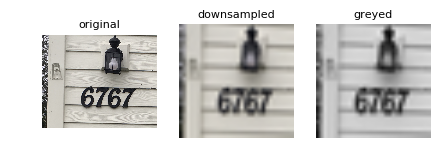

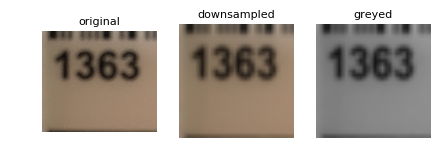

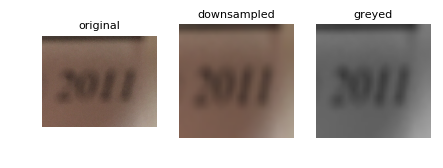

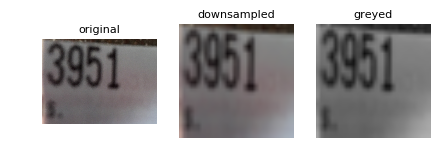

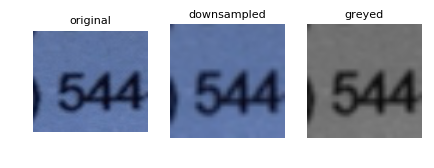

In [123]:
#test sample pre-processing

plt.rcParams['figure.figsize'] = (5.0, 5.0)
testsample=np.ndarray([5,32,32,1], dtype='float32')
testlabels=np.ndarray([5,1], dtype='int32')


def openjpg_resize_grey(filename,i):
    fig = plt.figure()
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    im=Image.open('./camerapictures/'+ filename+'.jpg')
    ax1.imshow(im)
    ax1.set_title('original', fontsize=8)
    ax1.axis('off')
    im=im.resize([32,32],Image.LANCZOS)
    ax2.imshow(im)
    ax2.set_title('downsampled', fontsize=8)
    ax2.axis('off')
    im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
    testsample[i,:,:,:]=im[:,:,:]
    im=Image.fromarray(im.reshape([32,32]))
    ax3.imshow(im)
    ax3.set_title('greyed', fontsize=8)
    ax3.axis('off')   
    testlabels[i,:]=int(filename)
    pass

openjpg_resize_grey('6767',0)
openjpg_resize_grey('1363',1)
openjpg_resize_grey('2011',2)
openjpg_resize_grey('3951',3)
openjpg_resize_grey('544',4)

print('testsample=',testsample.shape)
print('testlabels=',testlabels)

In [125]:
# Restore trained model, and make prediction on the given 10 random test data
#restoring model =digit classification

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_testsample=tf.placeholder(tf.float32, shape=(5, image_size, image_size, num_channels))

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    ######Stage1########
    conv=conv2d(data, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1)
    
    ######Stage2########
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    ######Stage3########
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    ######Stage4=fully connected and dropout ########
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]]) 
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]
  
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_testsample)
  
  # Predictions for the training, validation, and test data.
  predict = tf.pack([tf.nn.softmax(logits_0), 
                     tf.nn.softmax(logits_1), 
                     tf.nn.softmax(logits_2),
                     tf.nn.softmax(logits_3),
                     tf.nn.softmax(logits_4)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "CNN_multi_two_stages_final.ckpt")
  print("Model restored.")  
  test_prediction = session.run(test_prediction, feed_dict={tf_testsample : testsample})
  print('test_prediction=\n',test_prediction)
  print('Actual testlabels=\n[[ 6767.]\n[ 1363.]\n[ 2011.]\n[ 3951.]\n[  544.]]')

Model restored.
test_prediction=
 [[ 1  1 10 10 10]
 [ 4  1  3 10  0]
 [ 1  9 10 10  0]
 [ 3  6  2  5  0]
 [ 3  2  4  4 10]]
Actual testlabels=
[[ 6767.]
[ 1363.]
[ 2011.]
[ 3951.]
[  544.]]


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

**case1:** actual label 6767  =>num_digit:1  1 10 10 10  
    This image has a light fixture on top of the digits '6767' that might have been confused as actual digits. It only recognized as digit 1. 
    
**case2:** actual label 1363  =>num_digit:4  1  3 10  0  
    This got number of digit correct, first two digits, 1,3 were correct, but 6 and 3 were not recognized. It is not clear why it would be. 
    
**case3:** actual label 2011 =>num_digit:1  9 10 10  0  
    This didn't get number of digit or any single digit correctly. Poor focus and distorted digit image might be the reason. 
    
**case4:** actual label 3951 =>num_digit:3  6  2  5  0  
    This didn't get number of digit or any single digit correctly. Lack of bounding box wouldn't help.
    
**case5:** actual label 544 =>num_digit:3  2  4  4 10  
    This got number of digit correct, and last two digits, 4,4 were correct. 5 was misrecognized as 2. This type of font might not have been used in actual street house number dataset. 
    

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

No. The model performed poorly on captured pictures compared to testing on the realistic dataset. 

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [126]:
#with the pickeled dataset from the preprocessing above. 

pickle_file = 'SVHN_multi_rationedbbox_and_downsampledrawimage.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_raw = save['train_dataset_raw']
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  train_ratioed_bboxes = save['train_ratioed_bboxes']
  valid_dataset_raw = save['valid_dataset_raw']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  valid_ratioed_bboxes = save['valid_ratioed_bboxes']
  test_dataset_raw = save['test_dataset_raw']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  test_ratioed_bboxes = save['test_ratioed_bboxes']
  del save  
    
  print('Training set', train_dataset_raw.shape, train_dataset.shape, train_labels.shape,train_ratioed_bboxes.shape)
  print('Validation set', valid_dataset_raw.shape, valid_dataset.shape, valid_labels.shape,valid_ratioed_bboxes.shape)
  print('Test set',test_dataset_raw.shape, test_dataset.shape, test_labels.shape,test_ratioed_bboxes.shape)

Training set (230070, 32, 32, 1) (230070, 32, 32, 1) (230070, 6) (230070, 20)
Validation set (5684, 32, 32, 1) (5684, 32, 32, 1) (5684, 6) (5684, 20)
Test set (13068, 32, 32, 1) (13068, 32, 32, 1) (13068, 6) (13068, 20)


In [127]:
def accuracy(predictions, labels):

  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

#bbox accuracy 

def get_iou(a, b, epsilon=1e-5):
    """ Given two boxes `a` and `b` defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union score for these two boxes.

    Args:
        a:          (list of 4 numbers) [x1,y1,x2,y2]
        b:          (list of 4 numbers) [x1,y1,x2,y2]
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (float) The Intersect of Union score.
    """
    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)
    # handle case where there is NO overlap
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)*100
    return iou

def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)*100
    return iou

def find_wholebbox(step, train_ratioed_bboxes):
    ratiobox=train_ratioed_bboxes[step%batch_size].reshape([4,5])
    scaledbackbbox=ratiobox*32
    scaledbackbbox=np.array(scaledbackbbox,dtype=int)
    #print('scaled back bbox=\n',scaledbackbbox)

    # bounding box information of area encompassing all digits
    if len([x for x in scaledbackbbox[0,:] if x > 0])==0:
        im_top=0
    else:
        im_top = min(x for x in scaledbackbbox[0,:] if x > 0) 
    if len([x for x in scaledbackbbox[1,:] if x > 0])==0:
        im_left=0
    else:
        im_left = min(x for x in scaledbackbbox[1,:] if x > 0)  
    
    im_height = np.amax(scaledbackbbox[0,:]) + scaledbackbbox[2,[np.argmax(scaledbackbbox[0,:])]] - im_top
    im_width = np.amax(scaledbackbbox[1,:]) + scaledbackbbox[3,[np.argmax(scaledbackbbox[1,:])]] - im_left

    # resize bounding box and create points to crop 
    im_top = np.floor(1.0*im_top - 0.1 * im_height)
    im_left = np.floor(1.0*im_left - 0.1 * im_width)
    im_bottom = np.amin([np.ceil(1.0*im_top + 1.2 * im_height), 32])
    im_right = np.amin([np.ceil(1.0*im_left + 1.2 * im_width), 32])
    bbox =  (im_left, im_top, im_right ,im_bottom )
    return bbox

In [138]:
# BBox regression

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset_raw = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  #tf_train_labels = tf.placeholder(tf.int64, shape=(batch_size, 6))
  tf_train_ratioed_bboxes=tf.placeholder(tf.float32, shape=(batch_size, 20))
  #tf_valid_dataset = tf.constant(valid_dataset)
  #tf_test_dataset = tf.constant(test_dataset)  
  tf_valid_dataset_raw = tf.constant(valid_dataset_raw)
  tf_test_dataset_raw = tf.constant(test_dataset_raw)
  tf_valid_ratioed_bboxes=tf.constant(valid_ratioed_bboxes)
  tf_test_ratioed_bboxes=tf.constant(test_ratioed_bboxes)


  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth


  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

 
  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], stddev=0.1, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))


  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata, bbox): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    error_bbox = tf.reduce_mean(tf.square((bbox[:,0] - predictions_bbox[:,0]))+
                                tf.square((bbox[:,1] - predictions_bbox[:,1]))+
                                tf.square((bbox[:,2] - predictions_bbox[:,2]))+
                                tf.square((bbox[:,3] - predictions_bbox[:,3]))+
                                tf.square((bbox[:,4] - predictions_bbox[:,4]))+
                                tf.square((bbox[:,5] - predictions_bbox[:,5]))+
                                tf.square((bbox[:,6] - predictions_bbox[:,6]))+
                                tf.square((bbox[:,7] - predictions_bbox[:,7]))+
                                tf.square((bbox[:,8] - predictions_bbox[:,8]))+
                                tf.square((bbox[:,9] - predictions_bbox[:,9]))+
                                tf.square((bbox[:,10] - predictions_bbox[:,10]))+
                                tf.square((bbox[:,11] - predictions_bbox[:,11]))+
                                tf.square((bbox[:,12] - predictions_bbox[:,12]))+
                                tf.square((bbox[:,13] - predictions_bbox[:,13]))+
                                tf.square((bbox[:,14] - predictions_bbox[:,14]))+
                                tf.square((bbox[:,15] - predictions_bbox[:,15]))+
                                tf.square((bbox[:,16] - predictions_bbox[:,16]))+
                                tf.square((bbox[:,17] - predictions_bbox[:,17]))+
                                tf.square((bbox[:,18] - predictions_bbox[:,18]))+
                                tf.square((bbox[:,19] - predictions_bbox[:,19]))
                               )
    #error_bbox = tf.reduce_mean(tf.square(bbox - predictions_bbox))
    return [ predictions_bbox, error_bbox ]


  ##################################################################################
  ###Start of network architecture.
  ##################################################################################
  def bboxregressor(rawimgdata, ratioed_bboxes):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox, cost_bbox = regression_bbox(h_pool3_flat, ratioed_bboxes)
    return [pred_bbox, cost_bbox]

 
  ##################################################################################
  ###End of network architecture.
  ##################################################################################
    
  # Training computation.
  [pred_bbox, cost_bbox]=bboxregressor(tf_train_dataset_raw, tf_train_ratioed_bboxes)
 
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(1e-2, global_step, 100000, 0.95)
  optimizer_bbox = tf.train.AdagradOptimizer(learning_rate).minimize(cost_bbox, global_step=global_step)


 
  saver = tf.train.Saver()

num_steps = 230071 #230071
points = [[], [], []] # points[0]=n of iteration, points[1]=cost, points[3]=accuracy

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
     
    #bbox regression: (top,left,height,width)
    batch_data_bbox = train_dataset_raw[offset:(offset + batch_size), :, :, :]
    batch_labels_bbox = train_ratioed_bboxes[offset:(offset + batch_size), :]
    feed_dict_bbox = {tf_train_dataset_raw : batch_data_bbox, tf_train_ratioed_bboxes : batch_labels_bbox}
    _, l_bbox, predictions_train_bbox = session.run([optimizer_bbox, cost_bbox, pred_bbox], feed_dict=feed_dict_bbox)
    
    #Get actual whole bbox area including all digits and calculate iou
    bbox_actual=find_wholebbox(step, train_ratioed_bboxes)
    bbox_pred=find_wholebbox(step, predictions_train_bbox)
    bbox_iou=get_iou(bbox_pred, bbox_actual, epsilon=1e-5)

    if (step % 100 == 0):
      print('Minibatch loss_bbox at step %d: %f' % (step, l_bbox))
      points[0].append(step+1)
      points[1].append(l_bbox)
      points[2].append(bbox_iou)
      print('Step', step, 'bbox accuracy: %.1f%%' % bbox_iou)
      
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
  save_path = saver.save(session, "CNN_multi_two_stages_regressiononly_tmp.ckpt")
  print("Model saved in file: %s" % save_path)


Initialized
Minibatch loss_bbox at step 0: 1279767.500000
Step 0 bbox accuracy: 0.0%
Minibatch loss_bbox at step 100: 1334.280762
Step 100 bbox accuracy: 0.0%
Minibatch loss_bbox at step 200: 790.853821
Step 200 bbox accuracy: 0.0%
Minibatch loss_bbox at step 300: 443.705719
Step 300 bbox accuracy: 36.4%
Minibatch loss_bbox at step 400: 48.240337
Step 400 bbox accuracy: 0.0%
Minibatch loss_bbox at step 500: 12.333097
Step 500 bbox accuracy: 0.0%
Minibatch loss_bbox at step 600: 3.857441
Step 600 bbox accuracy: 0.0%
Minibatch loss_bbox at step 700: 7.618896
Step 700 bbox accuracy: 54.8%
Minibatch loss_bbox at step 800: 1.809563
Step 800 bbox accuracy: 0.0%
Minibatch loss_bbox at step 900: 1.424317
Step 900 bbox accuracy: 49.9%
Minibatch loss_bbox at step 1000: 0.943262
Step 1000 bbox accuracy: 49.8%
Minibatch loss_bbox at step 1100: 0.989273
Step 1100 bbox accuracy: 80.2%
Minibatch loss_bbox at step 1200: 0.707264
Step 1200 bbox accuracy: 25.8%
Minibatch loss_bbox at step 1300: 0.710245

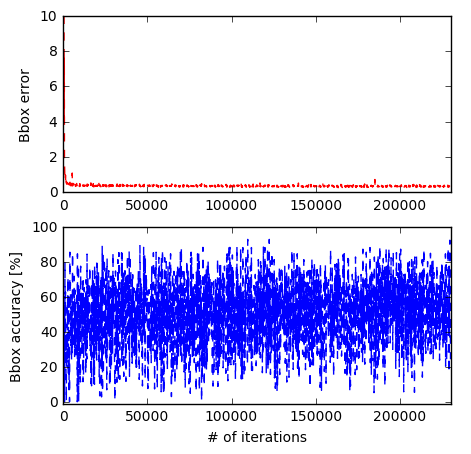

In [142]:
##################################
#Loss and accuracy over training 
##################################
fig = plt.figure()
ax = fig.add_subplot(111)    # The big subplot
ax.axis('off')
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)

ax1.plot(points[0], points[1], 'r--')
ax2.plot(points[0], points[2], 'b--')

ax2.set_xlabel('# of iterations')

ax1.axis([0, step, 0, 10])
ax1.set_ylabel('Bbox error')

ax2.axis([0, step, -1, 100])
ax2.set_ylabel('Bbox accuracy [%]')


n= 15


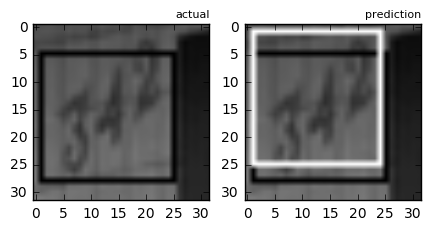

In [242]:
#Checking bbox after training-Open raw image, draw actual bbox vs. prediction bbox
plt.rcParams['figure.figsize'] = (5.0, 5.0)
fig = plt.figure()

def draw_bbox(nplot, img, bbox):  
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    draw = ImageDraw.Draw(img)
    if nplot==1: 
        color='black'
        ax1.set_title('actual',loc='right', fontsize=8)
        draw.rectangle(bbox,outline=color)
        ax1.imshow(img)
    elif nplot==2: 
        color='white'
        ax2.set_title('prediction',loc='right', fontsize=8)
        draw.rectangle(bbox,outline=color)
        ax2.imshow(img)
    del draw
    pass

n=random.randint(0,63) # 
print('n=',n)
imgarr=train_dataset_raw[n].reshape([32,32])
img=Image.fromarray(imgarr)

#ACTUAL BBOX in black
bbox_actual=find_wholebbox(n, train_ratioed_bboxes)
draw_bbox(1,img, bbox_actual)

#PREDICTION BBOX in white
bbox_pred=find_wholebbox(n, predictions_train_bbox)
draw_bbox(2,img, bbox_pred)

In [179]:
# Restore trained model, and make prediction on the given 10 random test data
#restoring model =digit classification

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_testsample=tf.placeholder(tf.float32, shape=(5, image_size, image_size, num_channels))

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    ######Stage1########
    conv=conv2d(data, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1)
    
    ######Stage2########
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    ######Stage3########
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    ######Stage4=fully connected and dropout ########
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]]) 
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]
  
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_testsample)
  
  # Predictions for the training, validation, and test data.
  predict = tf.pack([tf.nn.softmax(logits_0), 
                     tf.nn.softmax(logits_1), 
                     tf.nn.softmax(logits_2),
                     tf.nn.softmax(logits_3),
                     tf.nn.softmax(logits_4)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver_digit = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver_digit.restore(session, "CNN_multi_two_stages_final.ckpt")
  print("Model restored.")  
  test_prediction = session.run(test_prediction, feed_dict={tf_testsample : testsample})
  print('test_prediction=\n',test_prediction)
  print('Actual testlabels=\n[[ 6767.]\n[ 1363.]\n[ 2011.]\n[ 3951.]\n[  544.]]')

Model restored.
test_prediction=
 [[ 1  1 10 10 10]
 [ 4  1  3 10  0]
 [ 1  9 10 10  0]
 [ 3  6  2  5  0]
 [ 3  2  4  4 10]]
Actual testlabels=
[[ 6767.]
[ 1363.]
[ 2011.]
[ 3951.]
[  544.]]


In [223]:
#full convnet and L2 distance afterwards

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_testsample=tf.placeholder(tf.float32, shape=(5, image_size, image_size, num_channels))

  #variable
  #weight and biases for conv2d layers 
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  #digit classifier weight and biases for fully connected layer
  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  #bbox regression variable for fully connected layer
  w_bbox = tf.Variable(tf.truncated_normal([W_fc_shape, 20], stddev=0.1, dtype=tf.float32))
  b_bbox = tf.Variable(tf.zeros(20, dtype = tf.float32))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
  
  def regression_bbox(rawimgdata): # input is raw_downsampled image, output is predictions and error
    predictions_bbox = tf.add(b_bbox, tf.matmul(rawimgdata, w_bbox))
    return predictions_bbox

  def bboxregressor(rawimgdata):
    #********Stage1**********
    conv=conv2d(rawimgdata, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1) 

    #********Stage2**********
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    #********Stage3**********
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    #Stage4-1: fully connected for bbox regression**********
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]])
    pred_bbox= regression_bbox(h_pool3_flat)
    return pred_bbox

  # Training computation.
  pred_bbox=bboxregressor(tf_testsample)

 
  saver = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver.restore(session, "CNN_multi_two_stages_regressiononly_tmp.ckpt")
  print("Model restored.")  
  print('testsample=',testsample.shape)
  pred_bbox = session.run(pred_bbox, feed_dict={tf_testsample : testsample})
  print('pred_bbox=n',pred_bbox_T.shape)


Model restored.
testsample= (5, 32, 32, 1)
pred_bbox=n (5, 4, 5)


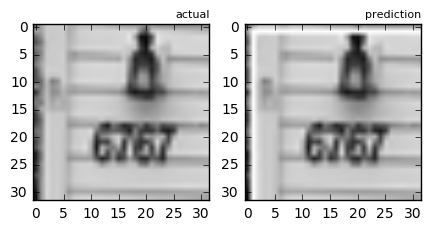

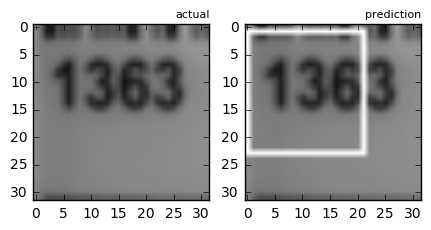

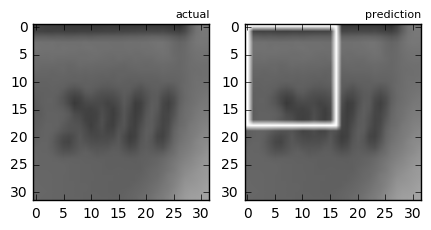

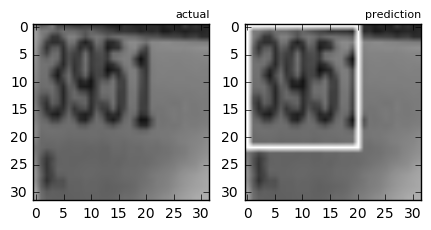

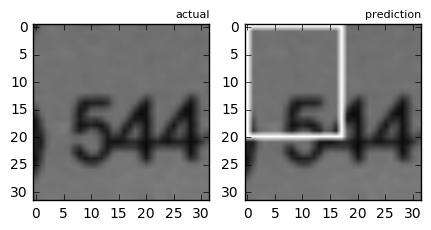

In [250]:
#PREDICTION BBOX in white
plt.rcParams['figure.figsize'] = (5.0, 5.0)

fig = plt.figure()

def draw_bbox(nplot, img, bbox):  
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    draw = ImageDraw.Draw(img)
    if nplot==1: 
        color='black'
        ax1.set_title('actual',loc='right', fontsize=8)
        draw.rectangle(bbox,outline=color)
        ax1.imshow(img)
    elif nplot==2: 
        color='white'
        ax2.set_title('prediction',loc='right', fontsize=8)
        draw.rectangle(bbox,outline=color)
        ax2.imshow(img)
    del draw
    pass

for n in range(0,len(testsample)):
    fig = plt.figure()
    imgarr=testsample[n].reshape([32,32])
    img=Image.fromarray(imgarr)

    #ACTUAL BBOX in black
    ax1 = fig.add_subplot(221)
    ax1.set_title('actual',loc='right', fontsize=8)
    ax1.imshow(img)
    
    #PREDICTION BBOX in white
    bbox_pred=find_wholebbox(n, pred_bbox)
    draw_bbox(2,img, bbox_pred)


testsample= (5, 32, 32, 1)
testlabels= [[6767]
 [1363]
 [2011]
 [3951]
 [ 544]]


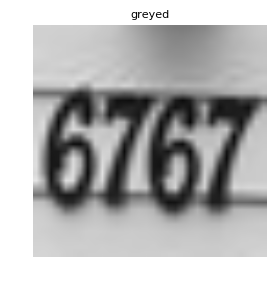

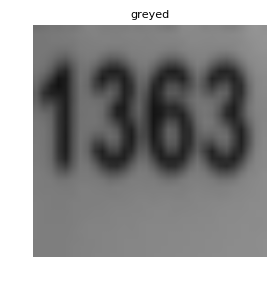

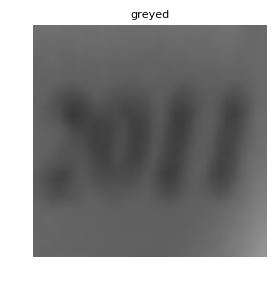

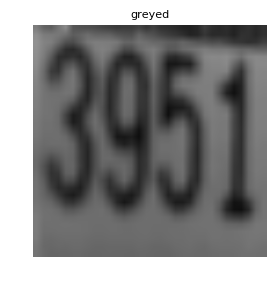

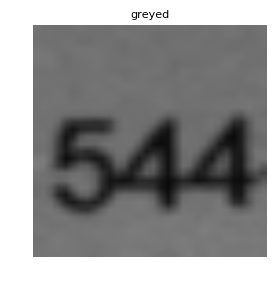

In [253]:
#After manually crop around the approximate bounding box, 

plt.rcParams['figure.figsize'] = (3.0, 3.0)
testsample=np.ndarray([5,32,32,1], dtype='float32')
testlabels=np.ndarray([5,1], dtype='int32')


def openjpg_resize_grey(filename,i):
    fig = plt.figure()
    ax3 = fig.add_subplot(111)
    im=Image.open('./camerapictures/aftercrop/'+ filename+'.jpg')
    im=im.resize([32,32],Image.LANCZOS)
    im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
    testsample[i,:,:,:]=im[:,:,:]
    im=Image.fromarray(im.reshape([32,32]))
    ax3.imshow(im)
    ax3.set_title('greyed', fontsize=8)
    ax3.axis('off')   
    testlabels[i,:]=int(filename)
    pass

openjpg_resize_grey('6767',0)
openjpg_resize_grey('1363',1)
openjpg_resize_grey('2011',2)
openjpg_resize_grey('3951',3)
openjpg_resize_grey('544',4)

print('testsample=',testsample.shape)
print('testlabels=',testlabels)

In [254]:
# Restore trained model, and make prediction on the given 10 random test data
#restoring model =digit classification

image_size=32
num_labels=11
num_channels=1

batch_size = 64

#Hyperparameters
patch_size = 5
keep_prob=1

depth0 = 1 #no pooling, no conv
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128
depth5 = 1024

pooling=3 #no pooling=0.5
W_fc_shape=int(math.ceil((image_size/(1.0*2**pooling))))*int(math.ceil(image_size/(1.0*2**pooling)))*depth4 #HYPERPARAMETER=depth

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_testsample=tf.placeholder(tf.float32, shape=(5, image_size, image_size, num_channels))

  #variable
  W_conv1 = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev=0.1)) 
  b_conv1 = tf.Variable(tf.zeros([depth1]))
  W_conv2 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv2 = tf.Variable(tf.zeros([depth2])) #HYPERPARAMETER=depth
  W_conv3 = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth2, depth4], stddev=0.1)) #HYPERPARAMETER=depth
  b_conv3 = tf.Variable(tf.zeros([depth4])) #HYPERPARAMETER=depth

  W_fc_0 = tf.get_variable("W0", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_1 = tf.get_variable("W1", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_2 = tf.get_variable("W2", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_3 = tf.get_variable("W3", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
  W_fc_4 = tf.get_variable("W4", shape=[W_fc_shape, num_labels],initializer=tf.contrib.layers.xavier_initializer())
    
  b_fc_0 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_1 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_2 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_3 = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  b_fc_4 = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

  def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

  # network architecture.
  def model(data):
 
    ######Stage1########
    conv=conv2d(data, W_conv1) + b_conv1
    h_conv1 = tf.nn.relu(conv)
    h_pool1 = max_pool_2x2(h_conv1)
    
    ######Stage2########
    conv=conv2d(h_pool1, W_conv2) + b_conv2 
    h_conv2 = tf.nn.relu(conv)
    h_pool2 = max_pool_2x2(h_conv2) 
    
    ######Stage3########
    conv=conv2d(h_pool2, W_conv3) + b_conv3 
    h_conv3 = tf.nn.relu(conv)
    h_pool3 = max_pool_2x2(h_conv3) 
    shape= h_pool3.get_shape().as_list()
    
    ######Stage4=fully connected and dropout ########
    h_pool3_flat = tf.reshape(h_pool3, [shape[0],shape[1]*shape[2]*shape[3]]) 
    logits_0=tf.matmul(h_pool3_flat, W_fc_0) + b_fc_0 
    logits_1=tf.matmul(h_pool3_flat, W_fc_1) + b_fc_1
    logits_2=tf.matmul(h_pool3_flat, W_fc_2) + b_fc_2
    logits_3=tf.matmul(h_pool3_flat, W_fc_3) + b_fc_3
    logits_4=tf.matmul(h_pool3_flat, W_fc_4) + b_fc_4
    
    return [logits_0,logits_1,logits_2,logits_3,logits_4]
  
  # Training computation.
  [logits_0,logits_1,logits_2,logits_3,logits_4] = model(tf_testsample)
  
  # Predictions for the training, validation, and test data.
  predict = tf.pack([tf.nn.softmax(logits_0), 
                     tf.nn.softmax(logits_1), 
                     tf.nn.softmax(logits_2),
                     tf.nn.softmax(logits_3),
                     tf.nn.softmax(logits_4)])
  test_prediction = tf.transpose(tf.argmax(predict, 2))
  saver_digit = tf.train.Saver()

with tf.Session(graph=graph) as session:
  saver_digit.restore(session, "CNN_multi_two_stages_final.ckpt")
  print("Model restored.")  
  test_prediction = session.run(test_prediction, feed_dict={tf_testsample : testsample})
  print('test_prediction=\n',test_prediction)
  print('Actual testlabels=\n[[ 6767.]\n[ 1363.]\n[ 2011.]\n[ 3951.]\n[  544.]]')

Model restored.
test_prediction=
 [[ 4  3  7  4  7]
 [ 4  1  3  6  3]
 [ 2  1  0 10  0]
 [ 4  1  9  5  0]
 [ 3  5  4  4 10]]
Actual testlabels=
[[ 6767.]
[ 1363.]
[ 2011.]
[ 3951.]
[  544.]]


### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

My regression model does not localize the numbers on testing set well. Accuracy(intersection of union) varies from 20-80%. So I manually cropped the digits, accuracy of digit classification significantly went up. 

**case1:**  
actual label 6767    
=>num_digit:1  1 10 10 10  : BEFORE CROP 0%  
=>num_digit:4  3  7  4  7  :AFTER CROP 50% accuracy of digit classification  

**case2:** actual label 1363    
=>num_digit:4  1  3 10  0  : BEFORE CROP 50%  
=>num_digit:4  1  3  6  3  :AFTER CROP 100%  
 
**case3:** actual label 2011   
=>num_digit:1  9 10 10  0  : BEFORE CROP 0%  
=>num_digit:2  1  0 10  0  :AFTER CROP 25%  

**case4:** actual label 3951   
=>num_digit:3  6  2  5  0  : BEFORE CROP 25%  
=>num_digit:4  1  9  5  0  :AFTER CROP 50%  
    
**case5:** actual label 544   
=>num_digit:3  2  4  4 10  : BEFORE CROP 66%  
=>num_digit:3  5  4  4 10  :AFTER CROP  100%  
    

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

As mentioned above in Question 10, my regression model doesn't calculate a bounding box very well for the numbers in the images I found. This will require hyperparemeter tunning on learning rate/optimizer, however, this further improvement is omitted this time here since one time training per parameter on 230K training dataset takes a full day. The reviewer's feedback is sincerely appreciated where could be improved to improve bounding box accuracy and how to train this computationally intensive batch process. 

After manually cropping, the examples of the localization are shown above. 

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.